# Basic SHRED Tutorial on Sea Surface Temperature

#### Import Libraries

In [ ]:
# PYSHRED
import pyshred
from pyshred import DataManager, SHRED, SHREDEngine

# Other helper libraries
import matplotlib.pyplot as plt
from scipy.io import loadmat
import torch
import numpy as np

#### Load in SST Data

In [2]:
sst_data = np.load("sst_data.npy")

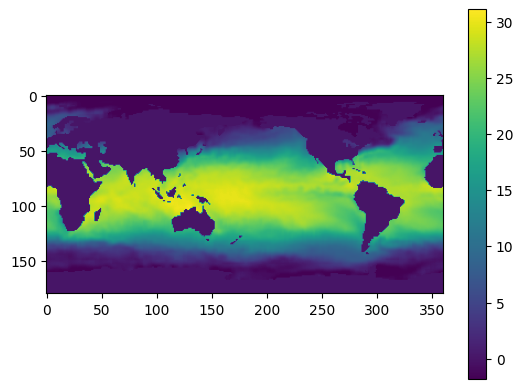

In [3]:
# Plotting a single frame
plt.figure()
plt.imshow(sst_data[0]) 
plt.colorbar()
plt.show()

#### Device Info

In [12]:
device = pyshred.set_device("auto")
# device = pyshred.set_device("cpu") # force CPU
# device = pyshred.set_device("cuda") # force CUDA
# device = pyshred.set_device("mps") # force MPS
# device = pyshred.set_device("cuda", device_id=0) # force specific GPU
pyshred.device_info()

=== PyShred Device Information ===
Current device: cpu
Device config: DeviceConfig(device_type=<DeviceType.MPS: 'mps'>, device_id=None, force_cpu=False, warn_on_fallback=True)

Device Availability:
  CUDA available: False
  MPS available: False
  CPU: Always available


#### Initialize Data Manager

In [4]:
manager = DataManager(
    lags = 52,
    train_size = 0.8,
    val_size = 0.1,
    test_size = 0.1,
)

#### Add datasets and sensors

In [5]:
manager.add_data(
    data = "sst_data.npy",
    id = "SST",
    random = 3,
    # mobile=,
    # stationary=,
    # measurements=,
    compress=False,
)

#### Analyze sensor summary

In [6]:
manager.sensor_summary_df

,data id,sensor_number,type,loc/traj
0,SST,0,stationary (random),"(81, 131)"
1,SST,1,stationary (random),"(155, 263)"
2,SST,2,stationary (random),"(153, 169)"


In [7]:
manager.sensor_measurements_df

,SST-0,SST-1,SST-2
0,28.449999,2.93,0.94
1,28.619999,3.35,1.09
2,28.279999,3.03,1.53
3,28.169999,2.95,1.60
4,28.179999,3.01,1.95
...,...,...,...
1395,29.999999,-0.57,-1.06
1396,29.769999,-0.32,-1.21
1397,29.809999,-0.14,-0.92
1398,29.889999,0.00,-0.66


#### Get train, validation, and test set

In [8]:
train_dataset, val_dataset, test_dataset= manager.prepare()

#### Initialize SHRED

In [9]:
shred = SHRED(sequence_model="LSTM", decoder_model="MLP", latent_forecaster="LSTM_Forecaster")

#### Fit SHRED

In [10]:
val_errors = shred.fit(train_dataset=train_dataset, val_dataset=val_dataset, num_epochs=10, sindy_regularization=0)
print('val_errors:', val_errors)

Fitting SHRED...
Epoch 1: Average training loss = 0.079502
Validation MSE (epoch 1): 0.036644
Epoch 2: Average training loss = 0.036274
Validation MSE (epoch 2): 0.034130
Epoch 3: Average training loss = 0.033781
Validation MSE (epoch 3): 0.034199
Epoch 4: Average training loss = 0.033450
Validation MSE (epoch 4): 0.033875
Epoch 5: Average training loss = 0.033123
Validation MSE (epoch 5): 0.033502
Epoch 6: Average training loss = 0.032411
Validation MSE (epoch 6): 0.032883
Epoch 7: Average training loss = 0.028727
Validation MSE (epoch 7): 0.022372
Epoch 8: Average training loss = 0.018934
Validation MSE (epoch 8): 0.016510
Epoch 9: Average training loss = 0.016190
Validation MSE (epoch 9): 0.014858
Epoch 10: Average training loss = 0.015114
Validation MSE (epoch 10): 0.015208
val_errors: [0.0366443  0.03413025 0.0341986  0.03387529 0.03350158 0.03288335
 0.0223723  0.01651014 0.01485774 0.01520807]


#### Evaluate SHRED

In [11]:
train_mse = shred.evaluate(dataset=train_dataset)
val_mse = shred.evaluate(dataset=val_dataset)
test_mse = shred.evaluate(dataset=test_dataset)
print(f"Train MSE: {train_mse:.3f}")
print(f"Val   MSE: {val_mse:.3f}")
print(f"Test  MSE: {test_mse:.3f}")

Train MSE: 0.012
Val   MSE: 0.015
Test  MSE: 0.017


#### Initialize SHRED Engine for Downstream Tasks

In [12]:
engine = SHREDEngine(manager, shred)

#### Sensor Measurements to Latent Space

In [13]:
test_latent_from_sensors = engine.sensor_to_latent(manager.test_sensor_measurements)

#### Forecast Latent Space (No Sensor Measurements)

In [14]:
val_latents = engine.sensor_to_latent(manager.val_sensor_measurements)
init_latents = val_latents[-shred.latent_forecaster.seed_length:] # seed forecaster with final lag timesteps of latent space from val
h = len(manager.test_sensor_measurements)
test_latent_from_forecaster = engine.forecast_latent(h=h, init_latents=init_latents)

#### Decode Latent Space to Full-State Space

In [15]:
test_prediction = engine.decode(test_latent_from_sensors) # latent space generated from sensor data
test_forecast = engine.decode(test_latent_from_forecaster) # latent space generated from latent forecasted (no sensor data)

Compare final frame in prediction and forecast to ground truth:

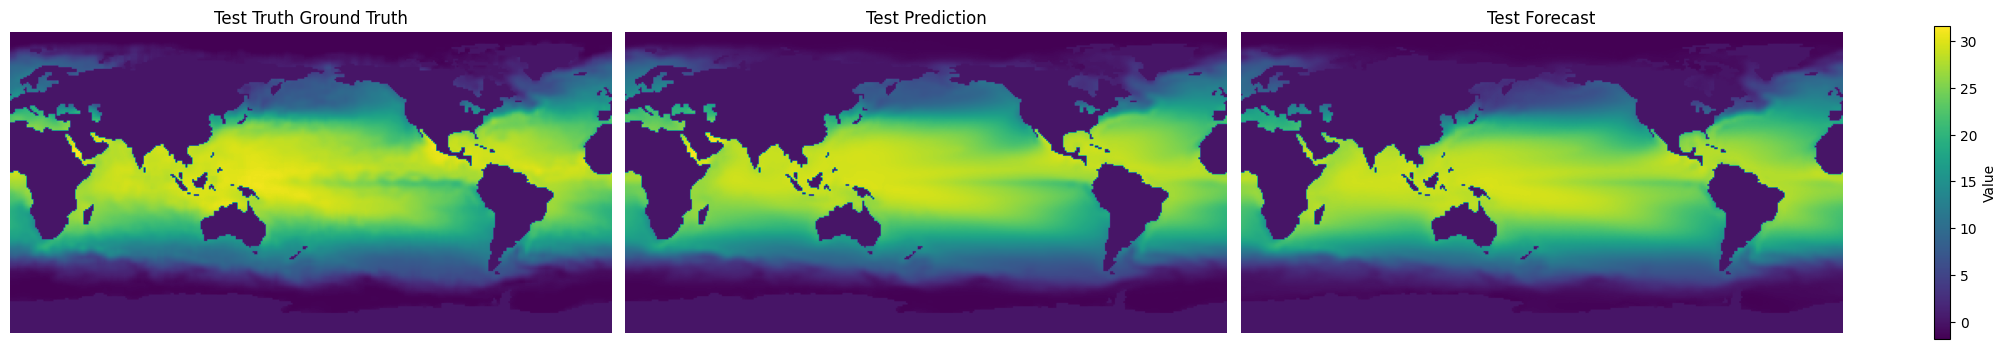

In [16]:
truth      = sst_data[-1]
prediction = test_prediction['SST'][-1]
forecast   = test_forecast['SST'][-1]

data   = [truth, prediction, forecast]
titles = ["Test Truth Ground Truth", "Test Prediction", "Test Forecast"]

vmin, vmax = np.min([d.min() for d in data]), np.max([d.max() for d in data])

fig, axes = plt.subplots(1, 3, figsize=(20, 4), constrained_layout=True)

for ax, d, title in zip(axes, data, titles):
    im = ax.imshow(d, vmin=vmin, vmax=vmax)
    ax.set(title=title)
    ax.axis("off")

fig.colorbar(im, ax=axes, label="Value", shrink=0.8)

#### Evaluate MSE on Ground Truth Data

In [17]:
# Train
t_train = len(manager.train_sensor_measurements)
train_Y = {'SST': sst_data[0:t_train]}
train_error = engine.evaluate(manager.train_sensor_measurements, train_Y)

# Val
t_val = len(manager.test_sensor_measurements)
val_Y = {'SST': sst_data[t_train:t_train+t_val]}
val_error = engine.evaluate(manager.val_sensor_measurements, val_Y)

# Test
t_test = len(manager.test_sensor_measurements)
test_Y = {'SST': sst_data[-t_test:]}
test_error = engine.evaluate(manager.test_sensor_measurements, test_Y)

print('---------- TRAIN ----------')
print(train_error)
print('\n---------- VAL   ----------')
print(val_error)
print('\n---------- TEST  ----------')
print(test_error)

---------- TRAIN ----------
              MSE      RMSE       MAE        R2
dataset                                        
SST      0.806486  0.898045  0.490421  0.365509

---------- VAL   ----------
              MSE      RMSE       MAE        R2
dataset                                        
SST      1.038167  1.018905  0.550346 -0.301883

---------- TEST  ----------
              MSE     RMSE       MAE        R2
dataset                                       
SST      1.196159  1.09369  0.597865 -0.431854
